# Turkish Lira images classification using Tensorflow

# New Section

**Turkish lira currency classification using CNN**

**Subject:** Algorithms for Massive Datasets 

**Course:** Data Science and Economics (University of Milan)

**Prof:** Dario Malchiodi

**Context**

This dataset is collected to develop applications for visually impaired people.

**Content**

Turkish lira dataset is published on Kaggle and released under the GPL 2.0 license. The trained classifier must take an image as input and provide as output the corresponding predictions w.r.t. the 5, 10, 20, 500, 100, and 200 lira classes.

Each banknote category is divided into folders.
Each folder contains 1000 images. 925 for training, 75 for validation.
Some data augmentation techniques applied to images (increase brightness, decrease brightness, flip, add salt&pepper noise).
Image Shape: (1280, 720, 3)

In [ ]:
#Importing Necessary Libraries:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Sequential

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [ ]:
tf.enable_eager_execution()

In [ ]:
!pip install kaggle

In [ ]:
#Upload your kaggle API json file:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pramodh941","key":"3af1e4df763d514df63dcbc9e6835bc4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Downloads the dataset:
!kaggle datasets download -d baltacifatih/turkish-lira-banknote-dataset

In [ ]:
#Extracts the Images from the Zip file downloaded:
from zipfile import ZipFile
file_name = "turkish-lira-banknote-dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

In [ ]:
#Specifying the path of the Images:
DATASET_PATH = /Users/pramodhreddy/Downloads/turkish-lira-banknote-dataset

In [ ]:
files = sorted(glob.glob(os.path.join(DATASET_PATH, "**/*.png")))

In [ ]:
img = cv2.imread(files[0])
height, width, channel = img.shape
    
print(f"Height: {height} Width: {width} Channel: {channel}")

Height: 720 Width: 1280 Channel: 3


In [ ]:
# Plotting some images:
%matplotlib inline
def show_image(img_path):
    img = mpimg.imread(img_path)
    plt.figure()
    plt.imshow(img)

File path: /kaggle/input/turkish-lira-banknote-dataset/10/10_1_0001.png
File path: /kaggle/input/turkish-lira-banknote-dataset/100/100_1_0001.png
File path: /kaggle/input/turkish-lira-banknote-dataset/20/20_1_0001.png
File path: /kaggle/input/turkish-lira-banknote-dataset/200/200_1_0001.png
File path: /kaggle/input/turkish-lira-banknote-dataset/5/5_1_0001.png
File path: /kaggle/input/turkish-lira-banknote-dataset/50/50_1_0001.png


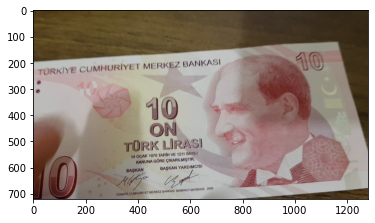

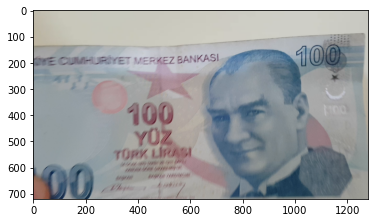

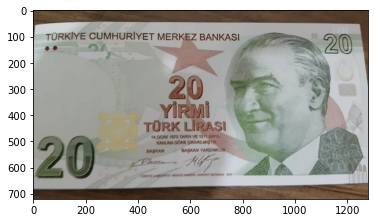

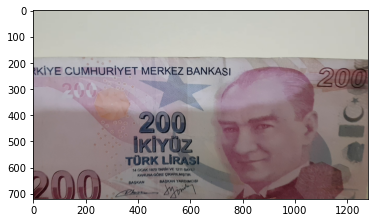

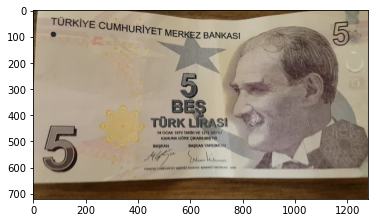

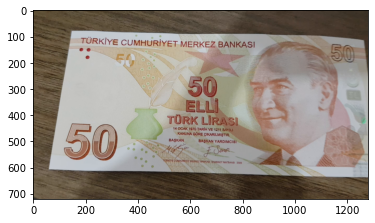

In [ ]:
image_idxs = [0, 1000, 2000, 3000, 4000, 5000]

for image_idx in image_idxs:
    print(f"File path: {files[image_idx]}")
    show_image(files[image_idx])

Our job is to build a classifier that can predict the correct labels for these images. We use Convolutional Neural Networks which are the best at Image classification tasks.

To achieve distributed training, In tensorflow configure the `TF_CONFIG` file like

```json
os.environ['TF_CONFIG'] = json.dumps({
    'cluster': {
        'worker': ["localhost:20000", "localhost:20001"]
    },
    'task': {'type': 'worker', 'index': 0}
})
```

and replace "localhost:20000" and "localhost:20001" with the ip addresses of your workers. More info [here](https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras).


We use the `MultiWorkerMirroredStrategy` for syncronized training across multiple machines with multiple GPUs. See [here](https://www.tensorflow.org/api_docs/python/tf/distribute/experimental/MultiWorkerMirroredStrategy) and [here](https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras) for more details.

In [ ]:
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

We resize each picture to 64x64 and set a batch size of 64 images per worker. In this example we are using a single worker, you need to change that in the `TF_CONFIG` file if you specify more than one worker.

In [ ]:
IMG_WIDTH = 64
IMG_HEIGHT = 64

NUM_WORKERS = 1
PER_WORKER_BATCH_SIZE = 64
GLOBAL_BATCH_SIZE = PER_WORKER_BATCH_SIZE * NUM_WORKERS

**Scalability in reading data:** We won't load all images into main memory, but we use `tf.Data` API in order to read data in small batches. In order to do this, we won't use the train/test split, but we will randomly split the data: 80% for training and 20% for testing.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  label_mode='categorical',
  batch_size=GLOBAL_BATCH_SIZE)

Found 6000 files belonging to 6 classes.
Using 4800 files for training.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_WIDTH, IMG_HEIGHT),
  label_mode='categorical',
  batch_size=GLOBAL_BATCH_SIZE)

Found 6000 files belonging to 6 classes.
Using 1200 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['10', '100', '20', '200', '5', '50']


In [ ]:
num_classes = len(class_names)

Converting the **RGB** Images to **Grayscale** (in the range [0,1]), which is more convenient for a neural network. This scaling will be done real-time while batch reading the images from disk.

In [ ]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255

    return image, label

**Parallel Computing:** We implement **prefetch** and **caching** of portions of the dataset in order to improve performance as suggested [here](https://www.tensorflow.org/guide/data_performance)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(scale, num_parallel_calls=AUTOTUNE).repeat().cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(scale, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

We now distribute the input across multiple devices. See [here](https://www.tensorflow.org/tutorials/distribute/input) for more details.

In [ ]:
dist_dataset = strategy.experimental_distribute_dataset(train_ds)

Let's now experiment on some CNN architectures for training:

In [ ]:
# Model 1: Using VGG blocks

with strategy.scope():
    modelVGG = Sequential()

    # VGG Blocks
    modelVGG.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
    modelVGG.add(Activation('relu'))
    modelVGG.add(Conv2D(32, (3, 3)))
    modelVGG.add(Activation('relu'))
    modelVGG.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG.add(Conv2D(64, (3, 3), padding='same'))
    modelVGG.add(Activation('relu'))
    modelVGG.add(Conv2D(64, (3, 3)))
    modelVGG.add(Activation('relu'))
    modelVGG.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG.add(Conv2D(128, (3, 3), padding='same'))
    modelVGG.add(Activation('relu'))
    modelVGG.add(Conv2D(128, (3, 3)))
    modelVGG.add(Activation('relu'))
    modelVGG.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG.add(Flatten())

    # Dense layers
    modelVGG.add(Dense(128))
    modelVGG.add(Activation('relu'))
    modelVGG.add(Dropout(0.5))
    modelVGG.add(Dense(num_classes, activation='softmax'))

    modelVGG.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

Early stopping to speed up training and reduce overfitting

In [ ]:
es = EarlyStopping(monitor='loss', verbose=1, mode='min', patience = 2, min_delta=0.01)

Training the model:

In [ ]:
historyVGG = modelVGG.fit(dist_dataset,
            epochs=15,
            steps_per_epoch = 75,
            callbacks=[es])

Epoch 1/15
75/75 [==============================] - 98s 1s/step - loss: 1.7391 - accuracy: 0.2375
Epoch 2/15
75/75 [==============================] - 76s 1s/step - loss: 1.1096 - accuracy: 0.5731
Epoch 3/15
75/75 [==============================] - 76s 1s/step - loss: 0.6765 - accuracy: 0.7473
Epoch 4/15
75/75 [==============================] - 76s 1s/step - loss: 0.4694 - accuracy: 0.8273
Epoch 5/15
75/75 [==============================] - 75s 1s/step - loss: 0.3408 - accuracy: 0.8808
Epoch 6/15
75/75 [==============================] - 76s 1s/step - loss: 0.2464 - accuracy: 0.9129
Epoch 7/15
75/75 [==============================] - 75s 1s/step - loss: 0.1862 - accuracy: 0.9346
Epoch 8/15
75/75 [==============================] - 75s 1s/step - loss: 0.1931 - accuracy: 0.9342
Epoch 9/15
75/75 [==============================] - 77s 1s/step - loss: 0.1264 - accuracy: 0.9550
Epoch 10/15
75/75 [==============================] - 76s 1s/step - loss: 0.1549 - accuracy: 0.9483
Epoch 11/15
75/75 [

Let's evaluate it on the test set

In [ ]:
modelVGG.evaluate(test_ds)

19/19 [==============================] - 15s 770ms/step - loss: 0.2038 - accuracy: 0.9492


[0.20383097231388092, 0.9491666555404663]

In [ ]:
# Model 2: VGG with Batch Normalisation:

with strategy.scope():
    modelVGG_BatchNorm = Sequential()

    # VGG Blocks
    modelVGG_BatchNorm.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
    modelVGG_BatchNorm.add( BatchNormalization( axis = 3 ) )
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(Conv2D(32, (3, 3)))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG_BatchNorm.add(Conv2D(64, (3, 3), padding='same'))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(Conv2D(64, (3, 3)))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG_BatchNorm.add(Conv2D(128, (3, 3), padding='same'))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(Conv2D(128, (3, 3)))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(MaxPooling2D(pool_size=(2, 2)))

    modelVGG_BatchNorm.add(Flatten())

    # Dense layers
    modelVGG_BatchNorm.add(Dense(128))
    modelVGG_BatchNorm.add(Activation('relu'))
    modelVGG_BatchNorm.add(Dropout(0.5))
    modelVGG_BatchNorm.add(Dense(num_classes, activation='softmax'))

    modelVGG_BatchNorm.compile(optimizer=tf.keras.optimizers.Adam(), 
                                  loss=tf.keras.losses.CategoricalCrossentropy(),
                                  metrics=["accuracy"])

In [ ]:
historyVGG_BatchNorm = modelVGG_BatchNorm.fit(dist_dataset,
                                                epochs=15,
                                                steps_per_epoch = 75,
                                                callbacks=[es])

Epoch 1/15
75/75 [==============================] - 75s 1s/step - loss: 1.0731 - accuracy: 0.5525
Epoch 2/15
75/75 [==============================] - 75s 995ms/step - loss: 0.4312 - accuracy: 0.8469
Epoch 3/15
75/75 [==============================] - 75s 1s/step - loss: 0.2297 - accuracy: 0.9258
Epoch 4/15
75/75 [==============================] - 75s 994ms/step - loss: 0.1681 - accuracy: 0.9481
Epoch 5/15
75/75 [==============================] - 75s 997ms/step - loss: 0.0965 - accuracy: 0.9708
Epoch 6/15
75/75 [==============================] - 74s 991ms/step - loss: 0.0893 - accuracy: 0.9710
Epoch 7/15
75/75 [==============================] - 74s 992ms/step - loss: 0.0603 - accuracy: 0.9827
Epoch 8/15
75/75 [==============================] - 75s 996ms/step - loss: 0.0646 - accuracy: 0.9815
Epoch 9/15
75/75 [==============================] - 74s 985ms/step - loss: 0.0376 - accuracy: 0.9896
Epoch 10/15
75/75 [==============================] - 75s 999ms/step - loss: 0.0779 - accuracy: 0.

In [ ]:
modelVGG_BatchNorm.evaluate(test_ds)

19/19 [==============================] - 0s 7ms/step - loss: 0.0961 - accuracy: 0.9692


[0.09609077125787735, 0.9691666960716248]

In [ ]:
# Using a simpler Network architecture:
with strategy.scope():
    model2 = Sequential()
    model2.add( ZeroPadding2D( input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), padding = ( 3, 3 ) ) )
    model2.add( Conv2D( 32, ( 7, 7 ), strides = (  1, 1 ) ) )
    model2.add( Activation( 'relu' ) )
    model2.add( MaxPooling2D( ( 2, 2 ) ) )
    model2.add( Flatten() )
    model2.add( Dense( 6 ) )
    model2.add(Dense(num_classes, activation='softmax'))
    
    model2.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

In [ ]:
history2 = model2.fit( dist_dataset, epochs = 20 , steps_per_epoch = 75, callbacks=[es])

Epoch 1/20
75/75 [==============================] - 75s 1s/step - loss: 1.5726 - accuracy: 0.3733
Epoch 2/20
75/75 [==============================] - 75s 993ms/step - loss: 0.9667 - accuracy: 0.6506
Epoch 3/20
75/75 [==============================] - 75s 1000ms/step - loss: 0.6672 - accuracy: 0.7675
Epoch 4/20
75/75 [==============================] - 74s 983ms/step - loss: 0.5050 - accuracy: 0.8308
Epoch 5/20
75/75 [==============================] - 74s 990ms/step - loss: 0.3828 - accuracy: 0.8792
Epoch 6/20
75/75 [==============================] - 74s 992ms/step - loss: 0.2356 - accuracy: 0.9340
Epoch 7/20
75/75 [==============================] - 74s 987ms/step - loss: 0.1788 - accuracy: 0.9517
Epoch 8/20
75/75 [==============================] - 75s 1000ms/step - loss: 0.1116 - accuracy: 0.9769
Epoch 9/20
75/75 [==============================] - 74s 989ms/step - loss: 0.1242 - accuracy: 0.9658
Epoch 10/20
75/75 [==============================] - 75s 1s/step - loss: 0.1093 - accuracy: 

In [ ]:
model2.evaluate(test_ds)

19/19 [==============================] - 0s 5ms/step - loss: 0.1665 - accuracy: 0.9467


[0.16649562120437622, 0.9466666579246521]

In [ ]:
# Simple Network with Batch Normalisation:
with strategy.scope():
    model3 = Sequential()
    model3.add( ZeroPadding2D( input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), padding = ( 3, 3 ) ) )
    model3.add( Conv2D( 32, ( 7, 7 ), strides = (  1, 1 ) ) )
    model3.add( BatchNormalization( axis = 3 ) )
    model3.add( Activation( 'relu' ) )
    model3.add( MaxPooling2D( ( 2, 2 ) ) )
    model3.add( Flatten() )
    model3.add( Dense( 6 ) )
    model3.add(Dense(num_classes, activation='softmax'))
    
    model3.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

In [ ]:
history3 = model3.fit( dist_dataset, epochs = 20 , steps_per_epoch = 75, callbacks=[es])

Epoch 1/20
75/75 [==============================] - 75s 1s/step - loss: 3.2955 - accuracy: 0.4808
Epoch 2/20
75/75 [==============================] - 75s 1s/step - loss: 0.5639 - accuracy: 0.8077
Epoch 3/20
75/75 [==============================] - 75s 997ms/step - loss: 0.3322 - accuracy: 0.8898
Epoch 4/20
75/75 [==============================] - 75s 1s/step - loss: 0.1929 - accuracy: 0.9400
Epoch 5/20
75/75 [==============================] - 75s 994ms/step - loss: 0.1517 - accuracy: 0.9571
Epoch 6/20
75/75 [==============================] - 74s 993ms/step - loss: 0.1246 - accuracy: 0.9621
Epoch 7/20
75/75 [==============================] - 75s 1s/step - loss: 0.0843 - accuracy: 0.9754
Epoch 8/20
75/75 [==============================] - 75s 993ms/step - loss: 0.0553 - accuracy: 0.9852
Epoch 9/20
75/75 [==============================] - 75s 1s/step - loss: 0.0611 - accuracy: 0.9827
Epoch 10/20
75/75 [==============================] - 74s 986ms/step - loss: 0.0326 - accuracy: 0.9927
Epoc

In [ ]:
model3.evaluate(test_ds)

19/19 [==============================] - 0s 5ms/step - loss: 0.1963 - accuracy: 0.9383


[0.19632461667060852, 0.9383333325386047]

**On Test Set:**

Our VGG network acheived an accuracy of 94.9%

VGG with Batch Normalisation acheived an accuracy of **96.9%**

Our Simple network acheived an accuracy of 94.6%

Simple network with Batch Normalisation acheived an accuracy of 93.8%

While we used Adaptive gradients as optimizer in all the networks, Stochastic gradient descent takes longer training time.

We conclude the standard VGG network with Batch Normalisation is the best training model among our experiments.

Further Improvements: Real-time Data Augmentation is an option - but takes longer training time and memory usage.